Market making is a trading strategy where traders simultaneously offers to buy and sell
finacial instruments to profit from the bid-ask spread

Since traders are providing liquidity to the market, market makers are crucial
in finance 

This program creates a RL agent that learns to make optimal market-making descisions
in sumulated enviorments


market maker profits from the bid-ask spread
while managing the risks associated with holding inventory

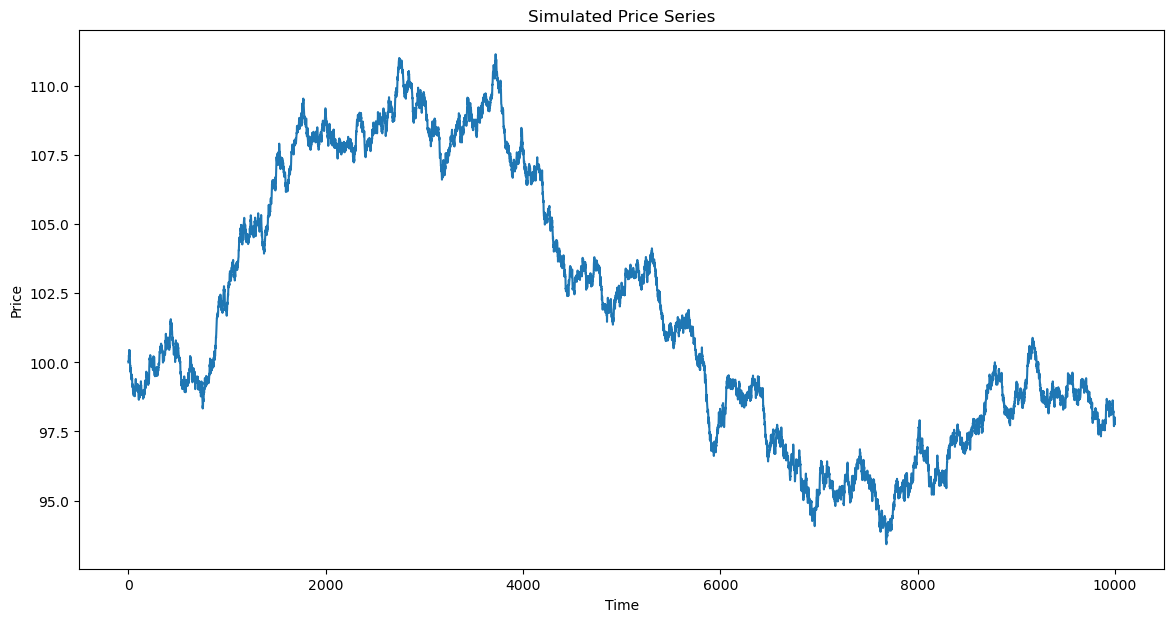

In [1]:
#Simulating the high-frequency market
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


#setting a random seed for reproducibility 
np.random.seed(42)

#generating synthetic price data 
def generate_price_series(length= 10000, start_price = 100): 
    prices =[start_price]
    for _ in range(length-1): 
        prices.append(prices[-1] + np.random.normal(0,0.1))
    return np.array(prices)

price_series = generate_price_series()

#Visualizing the price series 
plt.figure(figsize=(14,7))
plt.plot(price_series)
plt.title('Simulated Price Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [4]:
#Designing the trading enviroment
#Using OpenAI's gym to simulate the trading process
import gym 
from gym import spaces

class MarketMakingEnv(gym.Env): 
    """Custom Enviroment for Market Making"""
    metadata = {'render.modes' : ['human']}

    def __init__(self, price_series): 
        super(MarketMakingEnv, self).__init__()

        self.price_series = price_series
        self.max_steps = len(price_series)
        self.current_step = None

        #Defining action and observation space
        #Actions: [bid_price_offset, ask_price_offset]
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,), dtype = np.float32)

        #observations: [current_price, inventory]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(2,), dtype = np.float32
        )

        #Initializing state variables 
        self.inventory = 0
        self.cash = 0
        self.total_reward = 0

    def reset(self): 
        self.current_step = 0
        self.inventory = 0
        self.cash = 0
        self.total_reward = 0
        return self._next_observation()
    
    def _next_observation(self): 
        obs = np.array([
            self.price_series[self.current_step], 
            self.inventory
        ])
        return obs 
    
    def step(self, action): 
        #extracting bid and ask offsets 
        bid_offset, ask_offset = action

        #current market price 
        market_price = self.price_series[self.current_step]

        #set bid and ask prices 
        bid_price = market_price - bid_offset
        ask_price = market_price + ask_offset

        #simulating market interaction
        #for simplicity, assuming we always get filled 
        self.inventory += 1 #bought at bid price 
        self.cash -= bid_price 

        self.inventory -= 1 #sold at ask
        self.cash += ask_price

        #calculating reward 
        reward = (ask_price - bid_price) - (abs(bid_offset) + abs(ask_offset)) * 0.01
        self.total_reward += reward 

        #moving to the next time step
        self.current_step += 1 

        done = self.current_step >= self.max_steps -1 
        obs = self._next_observation()

        info = { 
            'inventory' : self.inventory,
            'cash' : self.cash, 
            'total_reward': self.total_reward
        }

        return obs, reward, done, info
    
    def render(self, mode = 'human', close=False): 
        print(f"Step: {self.current_step}")
        print(f"Price: {self.price_series[self.current_step]}")
        print(f"Inventory: {self.inventory}")
        print(f"Cash: {self.cash}")

In [16]:
#Implemnting RL Agent
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

#Creating enviorment
env = MarketMakingEnv(price_series)
env = DummyVecEnv([lambda: env])

#Initializing the agent 
model = PPO('MlpPolicy', env, verbose=1)

#training the agent 
model.learn(total_timesteps=100000)

#saving the model 
model.save('market_making_agent')

/Users/samys/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
------------------------------
| time/              |       |
|    fps             | 11277 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 2048  |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 6237        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020348236 |
|    clip_fraction        | 0.31        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 1.41e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 6.35        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0393     |
|    std                  | 0.983       |
|    value_loss           | 9.39        |
----------

In [17]:
#training the agent 
from stable_baselines3.common.callbacks import CheckpointCallback
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/',
                                         name_prefix='market_making_agent')
model.learn(total_timesteps=100000, callback=checkpoint_callback)

#evaluating models performance
model = PPO.load('market_making_agent')

#vreating new enviorment for testing 
test_env = MarketMakingEnv(price_series)
obs = test_env.reset()

for i in range(len(price_series)): 
    action, _states = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done: 
        break

-----------------------------
| time/              |      |
|    fps             | 9220 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 6163         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0044481903 |
|    clip_fraction        | 0.0896       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.79        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00242     |
|    n_updates            | 500          |
|    policy_gradient_loss | 0.00228      |
|    std                  | 0.593        |
|    value_loss           | 0.0106       |
----------------

In [19]:
# Load the trained agent
model = PPO.load('market_making_agent')

# Create a new environment for testing
test_env = MarketMakingEnv(price_series)
obs = test_env.reset()

for i in range(len(price_series)):
    action, _states = model.predict(obs)
    obs, rewards, done, info = test_env.step(action)
    test_env.render()
    if done:
        break

Step: 1
Price: 100.04967141530112
Inventory: 0
Cash: 2.0
Step: 2
Price: 100.035844985184
Inventory: 0
Cash: 4.0
Step: 3
Price: 100.10061383899406
Inventory: 0
Cash: 6.0
Step: 4
Price: 100.25291682463487
Inventory: 0
Cash: 8.0
Step: 5
Price: 100.22950148716254
Inventory: 0
Cash: 10.0
Step: 6
Price: 100.20608779146762
Inventory: 0
Cash: 12.0
Step: 7
Price: 100.36400907301837
Inventory: 0
Cash: 14.0
Step: 8
Price: 100.44075254593366
Inventory: 0
Cash: 16.0
Step: 9
Price: 100.39380510734017
Inventory: 0
Cash: 18.0
Step: 10
Price: 100.44806111169876
Inventory: 0
Cash: 20.0
Step: 11
Price: 100.40171934241752
Inventory: 0
Cash: 22.0
Step: 12
Price: 100.3551463670605
Inventory: 0
Cash: 24.0
Step: 13
Price: 100.3793425942171
Inventory: 0
Cash: 26.0
Step: 14
Price: 100.18801456975133
Inventory: 0
Cash: 28.0
Step: 15
Price: 100.01552278650003
Inventory: 0
Cash: 30.0
Step: 16
Price: 99.95929403357593
Inventory: 0
Cash: 32.0
Step: 17
Price: 99.85801092154249
Inventory: 0
Cash: 34.0
Step: 18
Price: 

In [20]:
pnl = test_env.cash + test_env.inventory * test_env.price_series[test_env.current_step]
print(f"Total P&L: {pnl}")

Total P&L: 19995.035952568054
